<a href="https://colab.research.google.com/github/Hong-Hyun-Seung/upstage-basic-deeplearning/blob/main/1012_MRC_Mission1_Extraction_based_MRC_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT를 활용해서 Extraction-based MRC 문제를 풀어보기

첫번째 미션에서는 **2강에서 배운 Extraction-based MRC**를 구현합니다 !

* Extraction-based MRC는 주어진 지문에 정답이 존재하는것이 가장 중요한 특징입니다.

* BERT 모델을 활용하여 문제를 풀어볼 예정이니, BERT에 대한 사전지식이 필요합니다 

* MRC에서 BERT를 어떻게 사용할까요 ? 아래 링크를 참고하세요 🙂
[Question Answering with a Fine-Tuned BERT](https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/)

* 해당 미션은 빈칸이 없습니다. 코드 한줄씩 살펴보면서 의미를 확인해보세요 !


```
🛠 Setup을 하는 부분입니다. 이전 과제에서 반복되는 부분이기 때문에 무지성 실행 하셔도 좋습니다.
💻 실습 코드입니다. 따라가면서 코드를 이해해보세요.
```

## 🛠초기설정

### 🛠Requirements

In [ ]:
# -q : q 옵션은 quiet의 약자
!pip install tqdm==4.48.0 -q
!pip install datasets==1.4.1 -q  #from torchvision import datasets와 다른것 주의!!!!
!pip install transformers==4.5.0 -q

     |████████████████████████████████| 67 kB 2.8 MB/s 
     |████████████████████████████████| 186 kB 4.3 MB/s 
     |████████████████████████████████| 243 kB 46.3 MB/s 
     |████████████████████████████████| 125 kB 49.7 MB/s 
     |████████████████████████████████| 2.1 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 38.9 MB/s 
     |████████████████████████████████| 3.3 MB 37.0 MB/s 


### 🛠난수 고정 및 버전 확인

In [ ]:
import random
import numpy as np
import torch
from datasets import load_dataset #from torchvision import datasets와 다른것 주의!!!!
# pytorch version, device 정보 확인하기 
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("device:[%s]."%(device))

PyTorch version:[1.9.0+cu111].
device:[cuda:0].


In [ ]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_seed(42) # magic number :)

### 🛠데이터 및 평가 지표 불러오기

In [ ]:
from datasets import load_dataset

datasets = load_dataset("squad_kor_v1")

Dataset squad_kor_v1 downloaded and prepared to /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7. Subsequent calls will reuse this data.


In [ ]:
len(datasets["train"])

60407

In [ ]:
from datasets import load_metric

metric = load_metric("squad")

##  💻 BERT를 활용하여 Extraction based QA 모델 구현하기

###  💻 Pre-trained 모델 불러오기

## Autoclasses
 ->automatically retrieve the relevant model given the name/path to the pretrained weights/config/vocabulary.<br>
 Instantiating one of AutoConfig, AutoModel, and AutoTokenizer will directly create a class of the relevant architecture

In [ ]:
"""
[간단 설명]

1. huggingface의 transformers 라이브러리를 통해 모델을 불러옵니다
2. AutoModel을 사용하면 원하는 모델을 이름만 바꾸어 불러 올 수 있습니다
3. QuestionAnswering을 위한 모델이 이미 구축되어있기 때문에 편하게 불러와서 사용 할 수 있습니다
4. 대용량 데이터로 미리 학습된 모델을 불러와서 사용합니다 (미리 학습된 모델 == Pretrained model)
"""

from transformers import (
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer
)

In [ ]:
# multilingual bert를 사용합니다
model_name = "bert-base-multilingual-cased" 

In [ ]:
config = AutoConfig.from_pretrained(
    model_name
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True #Whether or not to try to load the fast version of the tokenizer.
)
model = AutoModelForQuestionAnswering.from_pretrained(
    model_name,
    config=config
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-bas

In [ ]:
# model 구조 살펴보기 :
# (qa_outputs): Linear(in_features=768, out_features=2, bias=True)의 부분이 QA를 모델 구조
# out_features가 2인 이유는 start, end position을 찾기 위함입니다
model 

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

### 💻 파라미터 설정하기

학습에 필요한 파라미터를 설정합니다.  


In [ ]:
# 데이터 전처리를 위한 파라미터
max_seq_length = 384 # 질문과 컨텍스트, special token을 합한 문자열의 최대 길이
pad_to_max_length = True
doc_stride = 128 # 컨텍스트가 너무 길어서 나눴을 때 오버랩되는 시퀀스 길이

# 학습을 위한 파라미터 (파라미터는 편하게 수정해서 사용하시면 됩니다) 
max_train_samples = 16
max_val_samples = 16
preprocessing_num_workers = 4
batch_size = 16
num_train_epochs = 30
n_best_size = 20
max_answer_length = 30

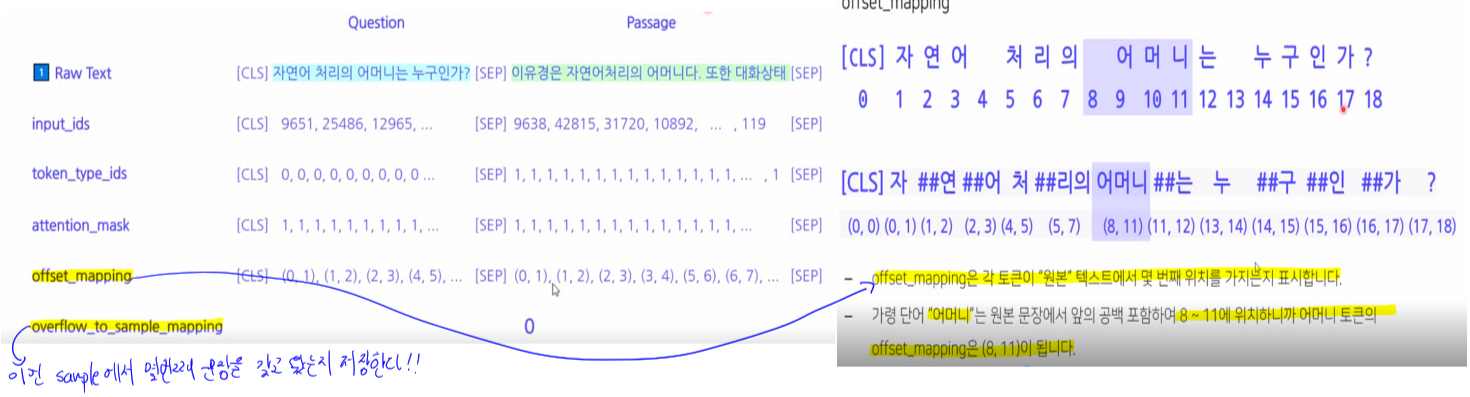

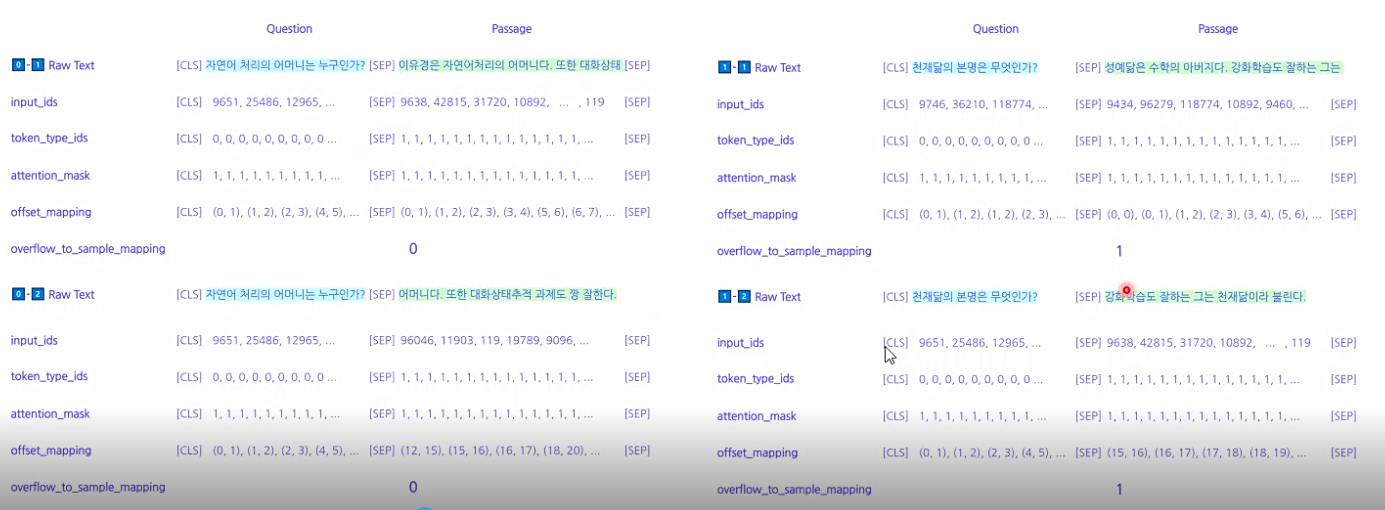

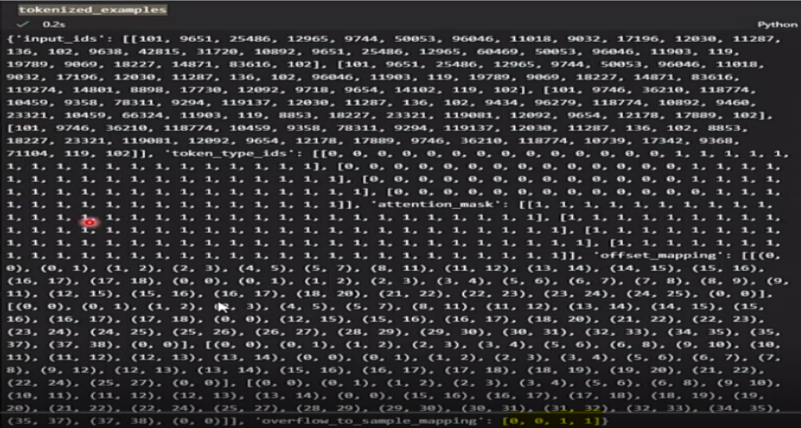

### 💻 데이터 전처리하기

참고 : 전처리 코드는 Lecture 1에서 제공된 것과 동일합니다 :)

In [ ]:
# Train을 위한 데이터 준비
def prepare_train_features(examples):
    # 주어진 텍스트를 토크나이징함
    # 이 때 텍스트의 길이가 max_seq_length를 넘으면 stride만큼 슬라이딩하며 여러 개로 나눔
    # 즉, 하나의 example에서 일부분이 겹치는 여러 sequence(feature)가 생길 수 있음
    tokenized_examples = tokenizer( #(위에 markdown 참고!!!)
        examples["question"],
        examples["context"],
        truncation="only_second",  # max_seq_length까지 truncate함 / pair의 두번째 파트(context)만 잘라냄
        max_length=max_seq_length,
        stride=doc_stride,
        return_overflowing_tokens=True, # 길이를 넘어가는 토큰들을 반환할 것인지
        return_offsets_mapping=True,  # 각 토큰에 대해 (char_start, char_end) 정보를 반환한 것인지
        padding="max_length",
    )
    
    # example 하나가 여러 sequence에 대응하는 경우를 위해 매핑이 필요
    overflow_to_sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # offset_mappings으로 토큰이 원본 context 내 몇번째 글자부터 몇번째 글자까지 해당하는지 알 수 있음
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # 정답지를 만들기 위한 리스트
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):#===================> 0 : [(0,1),(1,2),...] 1:[(0,1),1,2(),...] 2 : [(0,1),(1,2),...] 3:[(0,1),1,2(),...]
        input_ids = tokenized_examples["input_ids"][i]#=============> tokenized_examples["input_ids"]   ([[101,9746,....], [101,9651,...], [101,9651,...], [101,9651,...]])
                                                      #               중 i번째 list를 반환
        cls_index = input_ids.index(tokenizer.cls_token_id) # ======> input_ids([101,9746,...])에서 token(id:9746)이 몇번째 인지 반환(1 반환) => 이게 cls_index
        
        # 해당 example에 해당하는 sequence를 찾음
        sequence_ids = tokenized_examples.sequence_ids(i) # ========> 걍 tokentypeids와 동일한 기능. 
        '''
        token_type_ids가 "[cls]0000000....[sep]111111111...[sep]"였다면
        seque_ids는 이를 "None 0000000....None 111111111....None"으로 반환시켜주는 library
        '''
        # sequence가 속하는 example을 찾는다
        example_index = overflow_to_sample_mapping[i] # ============> overflow_to_sample_mapping(위 그림 참고), [0,0,1,1]에서 본인에 해당하는 값 뽑아온다(sample내에서 몇번째 문장이었는지 반환하겠지)
        answers = examples["answers"][example_index] # =============> 이건 밑에 코드 "train_dataset[0]" 찍어본 결과를 참고
        
        # 텍스트에서 answer의 시작점, 끝점
        answer_start_offset = answers["answer_start"][0]
        answer_end_offset = answer_start_offset + len(answers["text"][0])

        # 텍스트에서 현재 span의 시작 토큰 인덱스
        '''밑에 markdown 참고!!!!'''#(그림에서 token_start_index확인) => sep이후에 text부분의 시작을 찾는다!!!!
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1
        
        # 텍스트에서 현재 span 끝 토큰 인덱스
        '''밑에 markdown 참고!!!!'''#(그림에서 token_end_index확인)  => sep이후에 text부분의 끝을 찾는다!!!!
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1
        
        # answer가 현재 span을 벗어났는지 체크
        if not ( ''' !!!해당 if문 밑에 2번째 markdown참고!!!'''
            offsets[token_start_index][0] <= answer_start_offset
            and offsets[token_end_index][1] >= answer_end_offset
        ): #그니깐 이게 뭔소리냐면, 현재 offset이 answer 의 offset범위와 일치하는 중이면,
            tokenized_examples["start_positions"].append(cls_index)# => tokenized_examples["start_positions"]와 tokenized_examples["end_positions"]에 cls index append하는중
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # token_start_index와 token_end_index를 answer의 시작점과 끝점으로 옮김
            while (                                     '''token_start_index를 answer의 시작부분으로 찾아준다'''
                token_start_index < len(offsets)                        #  =>offset의 길이 ([(0,1),(1,2),...] 리스트의 길이) 안에 있는동안, 그리고
                and offsets[token_start_index][0] <= answer_start_offset#  =>offset이 answer의 시작 offset보다 왼쪽에 있는동안
            ):
                token_start_index += 1                                  #  =>token_start_index를 하나씩 늘려가고
            tokenized_examples["start_positions"].append(token_start_index - 1) #=>token_start_index를 만나면, tokenized_examples["start_positions"]에 append해준다
            while offsets[token_end_index][1] >= answer_end_offset:     # => 그리고 token_end_index를 끝에서 부터 왼쪽으로 이동하다가 answer의 젤 오른쪽 부분과 터치 하면
                token_end_index -= 1
            tokenized_examples["end_positions"].append(token_end_index + 1)#=>tokenized_examples["end_positions"]에 append해준다

    return tokenized_examples

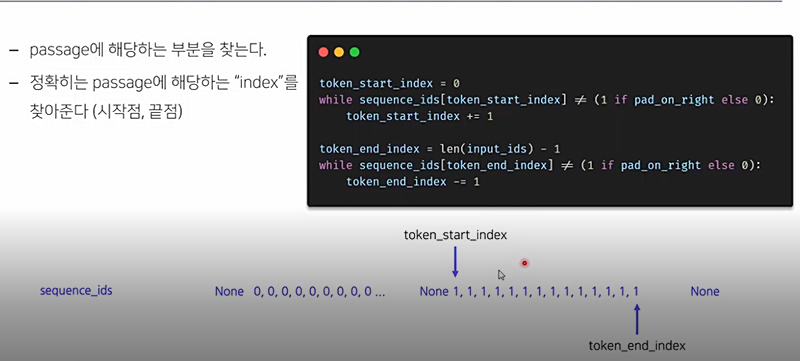

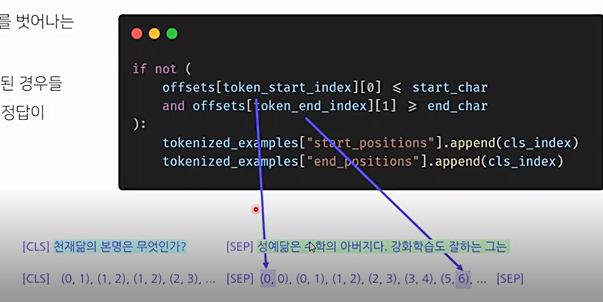

In [ ]:
train_dataset = datasets["train"]

In [ ]:
train_dataset[0]

{'answers': {'answer_start': [54], 'text': ['교향곡']},
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'id': '6566495-0-0',
 'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 'title': '파우스트_서곡'}

In [ ]:
# 전체 train dataset을 사용하는 예제가 아니고, sampling된 데이터를 사용하는 코드입니다. 적절하게 코드를 수정하여 사용하셔도 좋습니다.
train_dataset = train_dataset.select(range(max_train_samples)) 
column_names = datasets["train"].column_names
train_dataset = train_dataset.map(
            prepare_train_features,
            batched=True,
            num_proc=preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=True,
)

Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7/cache-74ee8f4c3fb49ad2.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7/cache-294ef19099e94a33.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7/cache-062117a464d28d4f.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7/cache-b53a8a59f928f5a9.arrow


In [ ]:
# validation을 위한 데이터 준비
def prepare_validation_features(examples):
    tokenized_examples = tokenizer(
        examples['question'],
        examples['context'],
        truncation="only_second",
        max_length=max_seq_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1

        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
# 전체 데이터로 평가
eval_examples = datasets["validation"]

# 샘플 데이터로 평가
# eval_examples = eval_examples.select(range(max_val_samples)) 
eval_dataset = eval_examples.map(
            prepare_validation_features,
            batched=True,
           num_proc=preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=True,
      )

Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7/cache-90f5a77d350a5f4a.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7/cache-c6d9210ace6b660d.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7/cache-43af54a883ab333b.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7/cache-bfee8d48bbf7e4bc.arrow


###  💻 Fine-tuning하기
사전에 학습된 모델을 불러온 후 KorQuAD 데이터셋으로 Finetuning을 진행합니다

(colab에서 간편히 script file을 업로드 하기위해 아래의 코드를 사용합니다. local 환경에서 사용시 아래의 코드를 주석 해제한 후 run 하시면 됩니다 )

`from trainer_qa import QuestionAnsweringTrainer`


`from utils_qa import postprocess_qa_predictions`


( 👀 참고 : local 환경에서는 위의 코드 주석을 해제하고 import 하면 되며, colab에서 여러번 Import를 진행할 경우 가끔 에러가 발생하는 케이스를 확인하여 colab에 script 파일을 업로드하는 코드를 제공하였습니다)

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('trainer_qa.py','wb').write(src)
from trainer_qa import QuestionAnsweringTrainer

Saving trainer_qa.py to trainer_qa (4).py


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils_qa.py','wb').write(src)
from utils_qa import postprocess_qa_predictions


Saving utils_qa.py to utils_qa (4).py


In [ ]:
from transformers import (
    default_data_collator, TrainingArguments, EvalPrediction
)
# from trainer_qa import QuestionAnsweringTrainer
# from utils_qa import postprocess_qa_predictions

# trainer_qa와 utils_qa는 script 파일로 제공

In [ ]:
# 모델 예측 값을 후처리 하는 함수 (qa 성능 향상에 필수적임)
def post_processing_function(examples, features, predictions):
    # Post-processing: original context에서 start logit과 end logit을 matching
    predictions = postprocess_qa_predictions(
        examples=examples,
        features=features,
        predictions=predictions,
        version_2_with_negative=False,
        n_best_size=n_best_size,
        max_answer_length=max_answer_length,
        null_score_diff_threshold=0.0,
        output_dir=training_args.output_dir,
        is_world_process_zero=trainer.is_world_process_zero(),
    )
    
    # Metric을 계산할 수 있는 format으로 수정
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in predictions.items()]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
    return EvalPrediction(predictions=formatted_predictions, label_ids=references)

In [ ]:
def compute_metrics(p: EvalPrediction):
    return metric.compute(predictions=p.predictions, references=p.label_ids)

In [ ]:
# 학습에 필요한 Arguments 정의
training_args = TrainingArguments(
    output_dir="outputs",
    do_train=True, 
    do_eval=True, 
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    save_strategy='no'
)

In [ ]:
trainer = QuestionAnsweringTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        eval_examples=datasets["validation"],
        tokenizer=tokenizer,
        data_collator=default_data_collator,
        post_process_function=post_processing_function,
        compute_metrics=compute_metrics,
    )

In [ ]:
train_result = trainer.train()

Step,Training Loss


In [ ]:
train_result

TrainOutput(global_step=60, training_loss=1.4066389719645183, metrics={'train_runtime': 105.6285, 'train_samples_per_second': 0.568, 'total_flos': 294060344647680.0, 'epoch': 30.0, 'init_mem_cpu_alloc_delta': 869007360, 'init_mem_gpu_alloc_delta': 709339648, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 14188544, 'train_mem_gpu_alloc_delta': 2128328704, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 8287101952})

### 💻 평가하기

In [ ]:
metrics = trainer.evaluate()

In [ ]:
metrics

{'epoch': 30.0, 'exact_match': 11.17076550051957, 'f1': 16.704218884682955}

### 💻 학습된 모델 불러오기

In [ ]:
finetuned_model = AutoModelForQuestionAnswering.from_pretrained('sangrimlee/bert-base-multilingual-cased-korquad')

In [ ]:
finetuned_model = finetuned_model.eval()

In [ ]:
finetuned_trainer = QuestionAnsweringTrainer(
    model=finetuned_model,
    args=TrainingArguments(
        output_dir="finetuned_outputs",
        do_eval=True, 
        per_device_eval_batch_size=batch_size,
    ),
    train_dataset=None,
    eval_dataset=eval_dataset,
    eval_examples=datasets["validation"],
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    post_process_function=post_processing_function,
    compute_metrics=compute_metrics,
)

In [ ]:
finetuned_metrics = finetuned_trainer.evaluate()

In [ ]:
finetuned_metrics